In [49]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [72]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session 
from sqlalchemy import create_engine, func, inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [1]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

NameError: name 'automap_base' is not defined

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [118]:
# Inspect the the session 
inspector = inspect(engine)
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

# Exploratory Climate Analysis

In [43]:
# Calculate the date 1 year ago from the last data point in the database

# Get the last date in the table 
row = session.query(func.Max(Measurement.date)).first()
last_date = row[0]

# Build a new string with fourth digit made one lower
# Will not work if the last_date occurs on the first year of a decade
one_year_from_last = last_date[0:3] + str(int(last_date[3])-1) + last_date[4:]
print(last_date)
print(one_year_from_last)

2017-08-23
2016-08-23


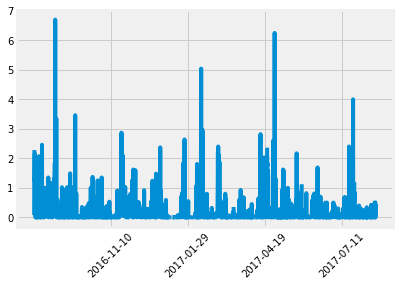

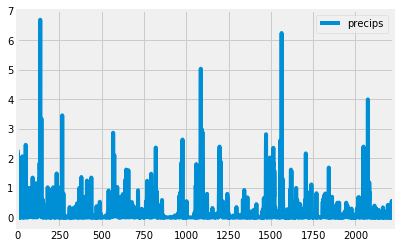

In [91]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
measurements = session.query(Measurement).filter( Measurement.date > one_year_from_last).order_by( Measurement.date.asc() )
precips = []
dates = []
locs = []
labels = []
iteration = 0
for measurement in measurements:
    iteration += 1
    precips.append( measurement.prcp)
    dates.append( measurement.date)
    if iteration % 500 == 0:
        locs.append(iteration)
        labels.append( measurement.date )
    

precip_plot = plt.plot(precips)
plt.xticks(locs, labels, rotation=45)

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame({'precips':precips, 'date': dates})
precip_df.dropna( inplace=True )
precip_df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot()


In [92]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precips
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [95]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station).count()
num_stations

9

In [116]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results = session.query(Measurement.station, func.Count(Measurement.id)).group_by(Measurement.station)\
    .order_by(func.Count(Measurement.id).desc())

most_active_station = results[0][0]

for result in results:    
    print(result)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [133]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
print(most_active_station)

#Query max temp
max_temps = session.query(func.Max(Measurement.tobs)).filter(Measurement.station==most_active_station)
max_temp = ''
for _ in max_temps: 
    max_temp = _[0]

#Query min temp
min_temps = session.query(func.Min(Measurement.tobs)).filter(Measurement.station==most_active_station)
min_temp = ''
for _ in min_temps: 
    min_temp = _[0]
    
#Query avg temp
avg_temps = session.query(func.Avg(Measurement.tobs)).filter(Measurement.station==most_active_station)
avg_temp = ''
for _ in avg_temps: 
    avg_temp = round(_[0],2)

print(f"Max Temp at station {most_active_station} is {max_temp} deg F")
print(f"Min Temp at station {most_active_station} is {min_temp} deg F")
print(f"Avg Temp at station {most_active_station} is {avg_temp} deg F")

USC00519281
Max Temp at station USC00519281 is 85.0 deg F
Min Temp at station USC00519281 is 54.0 deg F
Avg Temp at station USC00519281 is 71.66 deg F


Text(0, 0.5, 'Number of Days')

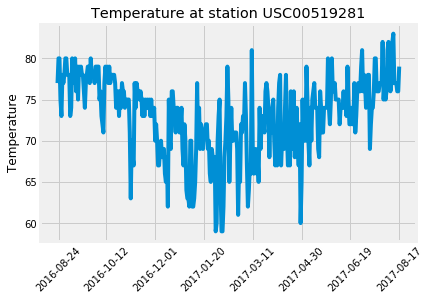

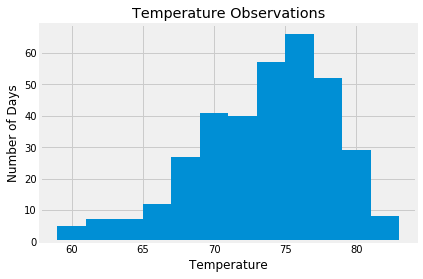

In [164]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date > one_year_from_last)\
    .order_by(Measurement.date.asc())

dates = []
tobs = []
labels = []
locs = []
iteration = 0
for result in results: 
    iteration += 1
    dates.append(result[0])
    tobs.append(result[1])
    if (iteration == 1 or iteration % 50 == 0):
        locs.append(iteration)
        labels.append(result[0])
    
plt.plot(tobs)
plt.xticks(locs, labels, rotation=45)
plt.title(f'Temperature at station {most_active_station}')
plt.ylabel('Temperature')

temps_df = pd.DataFrame({'tobs' : tobs, 'dates' : dates })
temps_df.hist(bins = 12)
plt.title('Temperature Observations')
plt.xlabel('Temperature')
plt.ylabel('Number of Days')



## Optional Challenge Assignment

In [155]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
